<a href="https://colab.research.google.com/github/aishwaryaanaidu/birdcall-identification/blob/main/final_bird_call_0.9_accu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pydub flask_ngrok flask_cors

In [2]:
import librosa, librosa.display
import os
from matplotlib import pyplot as plt
import IPython.display as ipd
import numpy as np
import torch
# matplotlib inline
from pydub import AudioSegment
# import FigureCanvasAgg as FigureCanvas
from os import path
import subprocess
import csv
from csv import writer

#Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import model_from_json
import pandas as pd
from PIL import Image
from keras.utils import np_utils
from sklearn import preprocessing
from matplotlib.image import imread

from google.colab import drive
drive.mount('/content/drive')

imheight = 360
imwidth = 540

le = preprocessing.LabelEncoder()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def img_to_numpy_array(path):
    return imread(path)

In [4]:
def create_spectrogram():
    # imheight = 50
    # imwidth = 34
    train_dir = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/train_spectr"
    test_dir = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/test_spectr"
    ####
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    ####
    for bird in os.listdir(directory)[:5]:
        dir_len = len(os.listdir(directory + "/" + bird)[:5])
        train_count = round(dir_len * 0.7)
        count = 1
        for filename in os.listdir(directory + "/" + bird)[:5]:
            if count <= train_count:
                new_dir = train_dir
            else:
                new_dir = test_dir
            src = directory + "/" + bird + "/" + filename
            save_path = new_dir + "/" + filename.split(".")[0] + ".png"
            # print(src)
            # print(save_path)

            dst = "test.wav"
            # params
            sampling = 21952
            hop_length = 245
            n_mels = 224
            n_fft = 892
            win_length = n_fft
            plt.rcParams["figure.figsize"] = [7.50, 5.00]
            plt.rcParams["figure.autolayout"] = True

            # convert mp3 to wav
            sound = AudioSegment.from_mp3(src)
            sound.export(dst, format="wav")
            signal, Fs = librosa.load(dst, sr=21952)

            # Load signal and plot
            signal,Fs = librosa.load(dst,sr=sampling,mono=True,res_type="kaiser_fast")
            plt.axis('off')

            # Create spectrogram and plot
            spectr = librosa.feature.melspectrogram(signal, sr=sampling, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length,
                                                    win_length=win_length, fmin=300)
            log_spectr = librosa.amplitude_to_db(spectr)

            librosa.display.specshow(log_spectr, sr=sampling, hop_length=hop_length)
            ####
            plt.savefig(save_path)
            
            gray = Image.open(save_path).convert('L')
            gray.save(save_path)
            ####
            

            count += 1
    # return train_list, test_list

In [17]:
def create_upload_spectrogram():
  upload_dir = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads"
    ####
  os.mkdir(upload_dir)
  src = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/uploads/upload.mp3"
  save_path = upload_dir + "/upload.png"
  # print(src)
  # print(save_path)

  dst = "test.wav"
  # params
  sampling = 21952
  hop_length = 245
  n_mels = 224
  n_fft = 892
  win_length = n_fft
  plt.rcParams["figure.figsize"] = [7.50, 5.00]
  plt.rcParams["figure.autolayout"] = True

  # convert mp3 to wav
  sound = AudioSegment.from_mp3(src)
  sound.export(dst, format="wav")
  signal, Fs = librosa.load(dst, sr=21952)

  # Load signal and plot
  signal,Fs = librosa.load(dst,sr=sampling,mono=True,res_type="kaiser_fast")
  plt.axis('off')

  # Create spectrogram and plot
  spectr = librosa.feature.melspectrogram(signal, sr=sampling, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length,
                                          win_length=win_length, fmin=300)
  log_spectr = librosa.amplitude_to_db(spectr)

  librosa.display.specshow(log_spectr, sr=sampling, hop_length=hop_length)
  ####
  plt.savefig(save_path)

  gray = Image.open(save_path).convert('L')
  gray.save(save_path)
  ####

In [6]:
def create_train_test(trl, tel):
    train = pd.read_csv("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/train.csv")
    test = pd.read_csv("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/test.csv")
    # y_test = np.zeros(len(tel[1:]), str)
    # y_train = np.zeros(len(trl[1:]), str)
    y_test = np.empty((len(tel[1:]), 1), dtype=np.dtype('U100'))
    y_train = np.empty((len(trl[1:]), 1), dtype=np.dtype('U100'))
    x_train = np.zeros((len(trl[1:]), imheight, imwidth))
    x_test = np.zeros((len(tel[1:]), imheight, imwidth))

    for i, f in enumerate(tel[1:]):
        y_test[i]     = f[1]
        x_test[i,:,:] = img_to_numpy_array(f[0])

    for i, f in enumerate(trl[1:]):
        y_train[i]     = f[1]
        x_train[i,:,:] = img_to_numpy_array(f[0])
    return x_train, y_train, x_test, y_test

In [7]:
def create_model(trl, tel):
    # train = pd.read_csv("train.csv")
    # test = pd.read_csv("test.csv")
    # x_train, y_train, x_test, y_test = train["path"], train["label"], test["path"], test["label"]
    x_train, y_train, x_test, y_test = create_train_test(trl, tel)

    print("Size of Training Data:", np.shape(x_train))
    print("Size of Training Labels:", np.shape(y_train))
    print("Size of Test Data:", np.shape(x_test))
    print("Size of Test Labels:", np.shape(y_test))
    
    # le = preprocessing.LabelEncoder()
    le.fit(["amerob", "blujay", "houspa", "norcar"])
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    

    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 1)
    x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 1)
    
    input_shape = (imheight, imwidth, 1)
    batch_size = 2
    epochs = 1

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))    
    model.add(Dense(128, activation='relu'))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
#     opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(x_train, y_train, batch_size=4, epochs=10, verbose=1, validation_data=(x_test, y_test))
    return model

In [8]:
directory = "drive/MyDrive/Colab Notebooks/IndianaBirds"
# trl, tel = create_spectrogram()

# create_spectrogram()
train_df = pd.read_csv("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/train.csv")
trl = train_df.values.tolist()
test_df = pd.read_csv("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/test.csv")
tel = test_df.values.tolist()
# print(tel)
# list_to_csv(trl, tel)

In [9]:
#Save created model
def save_model_to_disk(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/model.h5")
    print("Saved model to disk")

#Load saved model
def load_model_from_disk():
    # load json and create model
    json_file = open('drive/MyDrive/Colab Notebooks/IncreaseAccuracy/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/model.h5")
    print("Loaded model from disk")
    return loaded_model

In [10]:
num_classes = 4
if(os.path.isfile('drive/MyDrive/Colab Notebooks/IncreaseAccuracy/model.json')):
    m = load_model_from_disk()
else:
    m = create_model(trl, tel)
    save_model_to_disk(m)
# m = create_model(trl, tel)
print(m.summary())

Size of Training Data: (609, 360, 540)
Size of Training Labels: (609, 1)
Size of Test Data: (78, 360, 540)
Size of Test Labels: (78, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 358, 538, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 356, 536, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 178, 268, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3053056)           0         
                                                                 
 dropout (Dropout)           (None, 3053056)           0         
                                                                 
 dense (Dense)               (None, 128)               390791296 
                                                        

In [11]:
pip install shutil

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://bcc4-34-74-76-251.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
XC16898.mp3


127.0.0.1 - - [06/Dec/2021 06:03:30] "POST / HTTP/1.1" 200 -


[[7.4434116e-05 3.2910442e-03 1.2874234e-07 9.9663442e-01]]
['norcar']
XC17057.mp3


127.0.0.1 - - [06/Dec/2021 06:04:02] "POST / HTTP/1.1" 200 -


[[0.20519948 0.26189724 0.10497269 0.4279306 ]]
['norcar']
XC496849.mp3


127.0.0.1 - - [06/Dec/2021 06:04:42] "POST / HTTP/1.1" 200 -


[[7.0866401e-05 1.4188535e-05 4.5470351e-01 5.4521143e-01]]
['norcar']
XC37359.mp3


127.0.0.1 - - [06/Dec/2021 06:05:04] "POST / HTTP/1.1" 200 -


[[1.8589964e-02 7.7458137e-01 4.8312562e-04 2.0634548e-01]]
['blujay']
XC67401.mp3


127.0.0.1 - - [06/Dec/2021 06:05:39] "POST / HTTP/1.1" 200 -


[[0.0165325  0.02687889 0.00434148 0.95224714]]
['norcar']
XC62768.mp3


127.0.0.1 - - [06/Dec/2021 06:06:04] "POST / HTTP/1.1" 200 -


[[0.04877733 0.4987952  0.00200556 0.450422  ]]
['blujay']
XC16916.mp3


127.0.0.1 - - [06/Dec/2021 06:06:23] "POST / HTTP/1.1" 200 -


[[0.3542546  0.02947421 0.00089892 0.61537224]]
['norcar']
XC121738.mp3


127.0.0.1 - - [06/Dec/2021 06:08:10] "POST / HTTP/1.1" 200 -


[[9.9806448e-07 5.6463243e-05 9.9923611e-01 7.0645253e-04]]
['houspa']


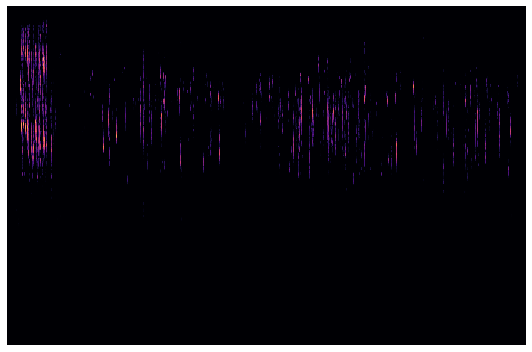

In [20]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok
from flask_cors import CORS, cross_origin
from flask import jsonify
import shutil
import PIL
import os
from PIL import Image

app = Flask(__name__)
cors = CORS(app)
app.config['CORS_HEADERS'] = 'Content-Type'
app.config['UPLOAD_FOLDER'] = 'drive/MyDrive/Colab Notebooks/IncreaseAccuracy/uploads'

run_with_ngrok(app)

@cross_origin()
@app.route('/', methods=['POST'])
def upload_file():
    uploaded_file = request.files['file']
    print(uploaded_file.filename)
    if os.path.exists("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads") and os.path.isdir("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads"):
      shutil.rmtree("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads")
    if uploaded_file.filename != '':
        uploaded_file.save(os.path.join(app.config['UPLOAD_FOLDER'], "upload.mp3"))

    create_upload_spectrogram()
    f_img = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads/upload.png"
    img = Image.open(f_img)
    img = img.resize((imwidth, imheight))
    img.save(f_img)
    # return { "message": "success" }
    temp = np.zeros((1, imheight, imwidth))
    temp[0,:,:] = img_to_numpy_array("drive/MyDrive/Colab Notebooks/IncreaseAccuracy/Spectrograms/uploads/upload.png")
    temp.reshape(temp.shape[0], imheight, imwidth, 1)
    output = np.array(m.predict(temp))
    print(output)
    # print(output[output.argmax()])
    predictions_test = le.inverse_transform([output.argmax()])
    print(predictions_test)
    data = { "predictions": predictions_test[0]}
    return data

if __name__ == "__main__":
  app.run()


In [13]:
# import PIL
# import os
# from PIL import Image


# f = "drive/MyDrive/Colab Notebooks/IncreaseAccuracy/train_spectr"

# for file in os.listdir(f):
#     f_img = f+"/"+file
#     img = Image.open(f_img)
#     img = img.resize((540,360))
#     img.save(f_img)